In [1]:
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

import pooltool as pt


def plot_ball_trajectory(ball: pt.Ball):
    """
    Plot the trajectory of the ball on a plane using the displacement vector (rvw[0]) with Plotly.

    Args:
        ball_history (BallHistory): The ball history object containing the ball states.
    """
    ball_history = ball.history_cts
    # Extract the x and y components of the displacement vector from each BallState
    x_coords = [state.rvw[0][0] for state in ball_history.states]
    y_coords = [state.rvw[0][1] for state in ball_history.states]

    # Create the plot
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=x_coords, y=y_coords, mode="lines+markers", name="Trajectory")
    )

    # Update plot layout
    fig.update_layout(
        title="Ball Trajectory",
        xaxis_title="X Position",
        yaxis_title="Y Position",
        showlegend=True,
        width=1000,
        height=1000,
    )

    # Show the plot
    fig.show()


def ball_history_to_dataframe(ball: pt.Ball, cts: bool = True) -> pd.DataFrame:
    """
    Convert BallHistory to a pandas DataFrame.

    Args:
        ball_history (BallHistory): The ball history object.

    Returns:
        pd.DataFrame: A DataFrame with columns for time, position, velocity, angular velocity, and state.
    """
    ball_history = ball.history_cts if cts else ball.history
    data = {
        "time": [state.t for state in ball_history.states],
        "rx": [state.rvw[0][0] for state in ball_history.states],
        "ry": [state.rvw[0][1] for state in ball_history.states],
        "vx": [state.rvw[1][0] for state in ball_history.states],
        "vy": [state.rvw[1][1] for state in ball_history.states],
        "v_angle": [
            np.degrees(pt.ptmath.angle([state.rvw[1][0], state.rvw[1][1]]))
            for state in ball_history.states
        ],
        "wx": [state.rvw[2][0] for state in ball_history.states],
        "wy": [state.rvw[2][1] for state in ball_history.states],
        "state": [state.s for state in ball_history.states],
    }
    return pd.DataFrame(data)


def _get_deflection_angle(df: pd.DataFrame) -> float:
    # remove 0 from the left
    start_idx = np.argmax(v_angle > 0)
    v_angle = v_angle[start_idx:]
    angle_in = v_angle[np.argmax(v_angle > 0)]
    idx = np.argmax((v_angle <= 0) | (v_angle > 90))
    # first angle that is greater than 90 or non-positive
    angle_out = v_angle[idx - 1]
    return angle_in - angle_out


def get_deflection_system(cut: float, V0: float = 2, b: float = 0.2):
    ballset = pt.get_ballset("pooltool_pocket")
    cue_ball = pt.Ball.create("cue", xy=(98, 50), ballset=ballset)
    obj_ball = pt.Ball.create("2", xy=(97, 50), ballset=ballset)
    cue = pt.Cue(cue_ball_id="cue")
    table = pt.Table.from_table_specs(
        specs=pt.BilliardTableSpecs(
            l=100,
            w=100,
        )
    )  # Use a very large table to make sure the cue ball eventually is rolling
    system = pt.System(
        cue=cue,
        table=table,
        balls={"cue": cue_ball, "2": obj_ball},
    )
    system.strike(V0=V0, phi=pt.aim.at_ball(system, "2", cut=cut), b=b)
    # Evolve the shot
    res = pt.simulate(system, inplace=True)
    return system


def get_deflection_angle(cut: float, V0: float = 2, b: float = 0.2) -> float:
    system = get_deflection_system(cut=cut, V0=V0, b=b)
    df = ball_history_to_dataframe(system.balls["cue"], cts=False)
    collision_time = None
    for event in system.events:
        if event.event_type == pt.EventType.BALL_BALL:
            collision_time = event.time
            break
    assert collision_time is not None, "ball never contacted"
    angle_in = df[df["time"] < collision_time]["v_angle"].iloc[-1]
    angle_out = df[(df["time"] > collision_time) & (df["state"] == 3)]["v_angle"].iloc[
        0
    ]
    return np.abs(angle_in - angle_out)

In [6]:
system = get_deflection_system(cut=10, V0=8)
_ = pt.continuize(system, dt=0.1, inplace=True)

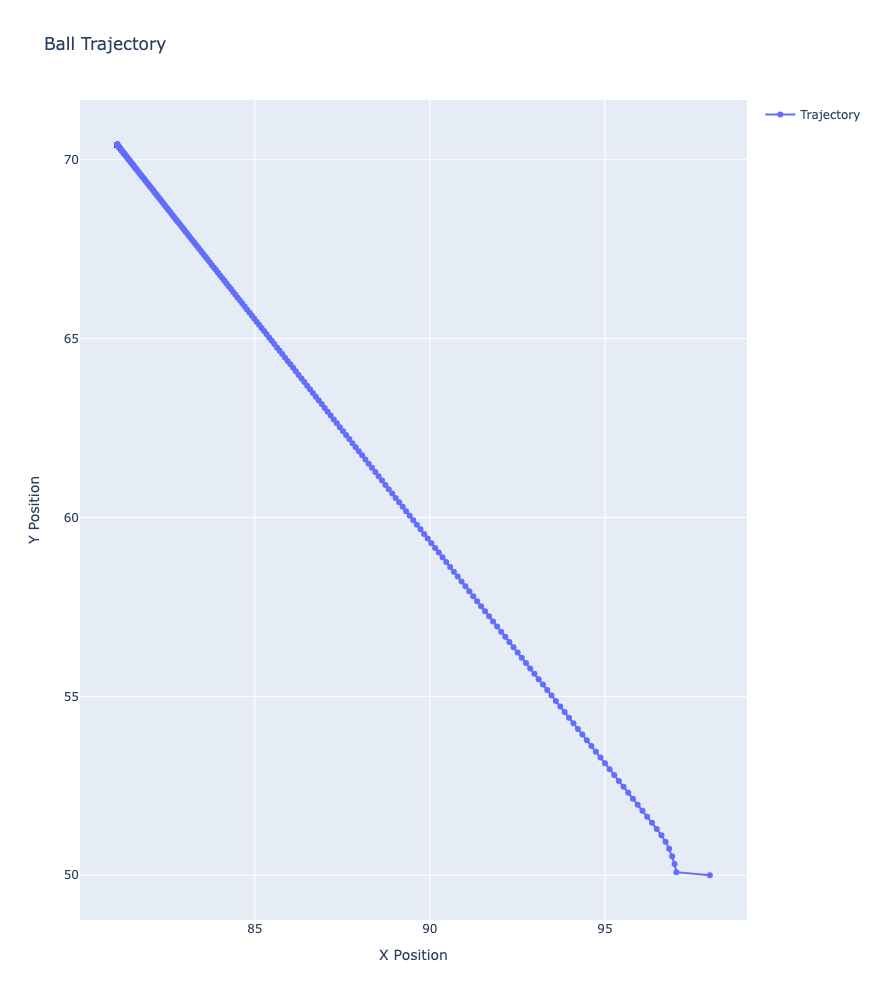

In [7]:
plot_ball_trajectory(system.balls["cue"])

In [66]:
df = ball_history_to_dataframe(system.balls["cue"], cts=False)
df.head(3)

,time,rx,ry,vx,vy,v_angle,wx,wy,state
0,0.000000,9.800000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,9.800000,5.00000,-14.035325,0.028967,179.881749,-0.253432,-122.793768,2
2,0.346368,5.056305,5.00979,-0.396609,2.280917,99.864041,-0.376140,-182.248917,2


## Verify 30 Degree Rule

In [4]:
cut_angles = np.linspace(5, 85, 50)
V0s = np.arange(0.5, 3, 0.2).round(2)
deflection_angles_df = pd.DataFrame(
    [
        [np.cos(np.radians(cut)), get_deflection_angle(cut=cut, V0=V0), V0]
        for cut in cut_angles
        for V0 in V0s
    ],
    columns=["fullness", "deflection_angle", "v0"],
)

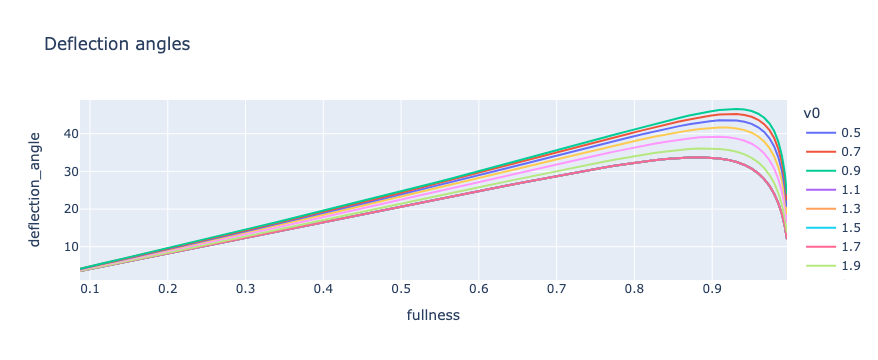

In [5]:
fig = px.line(
    deflection_angles_df,
    x="fullness",
    y="deflection_angle",
    color="v0",
    title="Deflection angles",
)
fig.show()